# Sampling Strategy code development for Mononuclear Complexes

## Profile What's reasonable from experiments:
Generate 2 sampling dataframes from which to sample:

A) Metals sampling dataframe:

1) Metal/Oxidation State(s) available (From Mendeleev)
2) Metal/Oxidation Sate + Coordination numbers observed (From CSD)

B) Ligands sampling dataframe:

3) Ligands that have covalent Metal-Ligand connections to specific atoms (e.g. M*-C* bonds) Select highest-propensity ligands from across the CSD. (Top N most frequent present - guessing ~20 would be good start)
4) Ligands that have non-covalent (not first-coordination shell) metal-ligand connections to specific atoms (e.g. M*-N-C* bonds) from across the CSD. (Top N most frequent present - guessing ~20 would be good start)
5) Ensure that ligands selected cover as much known differences in chemistry as possible (e.g. Oxygen vs Water vs. Hydroxyl vs. Oxo ...) - this definition can be a bit Nebulous I'm working on starting with different atom types as a measure of different chemistries.

Using the 2 dataframes a Zero-th order sampling strategy would be:
1) Randomly sample a row from A) (metal+oxidation state) and randomly select a coordination number from those observed in experiments.
2) Iteratively sample from B) (e.g. pick one ligand at a time) starting from the full B) that has ligand denticities less than or equal to the coordination number. For the next ligand, filter B) down to only those ligands that will not push the coordination complex charge less than -1 or greater than 4, and at most only fill out the coordination number selected. 
3) Any other constraints we should be considering?

Possible additional sampling considerations (that could take place after an initial DFT optimization, or before):
1) Adding N random solvent molecules around the metal centers? (water, octanol, thf) we could just use those that are commonly reported or parameterized with XTB, for example. 
2) Placing generated complexes close to each other.

In [9]:
from architector import (view_structures,convert_io_molecule)
import architector.io_ptable as io_ptable
# from pympipool.mpi import PyMPIExecutor # conda install -c conda-forge pympipool
# import concurrent.futures
# import multiprocessing
# import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import urllib.request
import mendeleev
from tqdm import tqdm

In [3]:
# Download the CSD, Architector-compatable structures dataframe from Zenodo.
urllib.request.urlretrieve('https://zenodo.org/records/7764697/files/1_CSD_compatable_structures.csv',
                           '1_CSD_compatable_structures.csv')

('1_CSD_compatable_structures.csv', <http.client.HTTPMessage at 0x111fd9630>)

In [2]:
df = pd.read_csv('1_CSD_compatable_structures.csv')

In [3]:
df.columns.values

array(['refcode', 'refcode_plus', 'csd_version', 'user_labeled_solvent',
       'user_labeled_oxidation_state', 'has_disorder', 'chemical_formula',
       'metal', 'natoms', 'user_labeled_charge', 'ligand_coordLists',
       'coordinating_atom_symbols', 'ligand_smiles', 'ligand_charges',
       'oxidation_state_assigned', 'total_charge_assigned', 'coreCN'],
      dtype=object)

In [4]:
df.total_charge_assigned.value_counts()

total_charge_assigned
 0    75334
 1    17289
 2    11867
-1     4581
-2     2453
 3     1890
 4      216
Name: count, dtype: int64

In [6]:
# Alot of these are just strings when we need them interpreted as python objects
df.iloc[0]

refcode                                                          AACANI10
refcode_plus                                              AACANI10_comp_0
csd_version                                                         3.0.9
user_labeled_solvent                                                  NaN
user_labeled_oxidation_state                                          2.0
has_disorder                                                        False
chemical_formula                                        C10 H18 N2 Ni1 O5
metal                                                                  Ni
natoms                                                                 36
user_labeled_charge                                                   NaN
ligand_coordLists                                ['[4, 8, 2, 15]', '[0]']
coordinating_atom_symbols                                       N,N,O,O,O
ligand_smiles                   ['O=C([O-])CN1CCCN(CCC1)CC(=O)[O-]', 'O']
ligand_charges                        

## First, let's get the metal information to sample:

A) Metals sampling dataframe

1) Metal/Oxidation State(s) available (From Mendeleev)
2) Metal/Oxidation Sate Coordination numbers observed (From CSD)

In [5]:
# Get dictionary of "common" oxidation states for each atom from mendeleev
# "Limited" metals includes everything that can be evaluated via XTB. e.g. Z<87
OCM_metals = io_ptable.limited_all_metals

In [6]:
good_metal_oxs = []
for met in OCM_metals: # Iterate over metals
    oxs = mendeleev.__dict__[met].oxidation_states() # Use mendeleev to pull out "common" oxidation states
    for ox in oxs: # Iterate over oxidation states
        if ox >= 0: # Make sure these are positive oxdiation states
            good_metal_oxs.append(met+','+str(int(ox))) # Create "Hash" of metal-oxidation states
print("Number of 'good' metal and oxdiation states to sample:",len(good_metal_oxs))

Number of 'good' metal and oxdiation states to sample: 91


In [7]:
metal_oxs = []
for i,row in df.iterrows():
    try:
        ox = int(row['oxidation_state_assigned'])
    except:
        ox = None
    metal_oxs.append(row['metal']+','+str(ox))
df['metal_ox'] = metal_oxs # Add to dataframe

Text(0, 0.5, 'Count in the CSD')

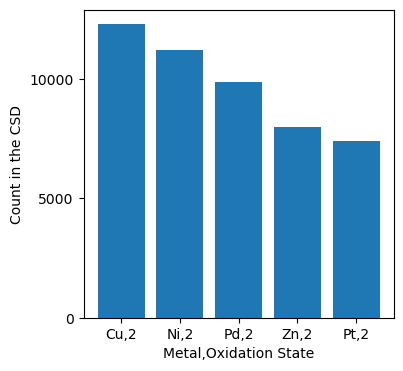

In [15]:
vcs = df.metal_ox.value_counts()
plt.figure(figsize=(4,4))
plt.bar(x=vcs.index.values[0:5],height=vcs.values[0:5])
plt.yticks([0,5000,10000])
plt.xlabel('Metal,Oxidation State')
plt.ylabel('Count in the CSD')

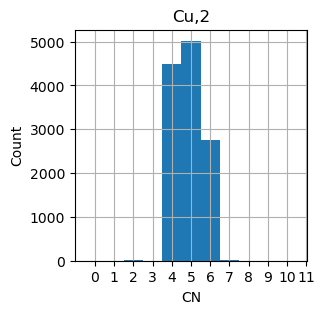

In [20]:
# Check that these make sense - generally they do
n = 6
metal_ox = 'Cu,2'
bins = np.arange(0,12,1)
plt.figure(figsize=(3,3))
ax = df[df.metal_ox == metal_ox].coreCN.hist(bins=bins,
                                                      align='left')
ax.set_xlabel('CN')
ax.set_ylabel('Count')
ax.set_title(metal_ox)
ax.set_xticks(bins);

In [11]:
good_metal_cns = []
good_metal_cn_counts = []
for met_ox in good_metal_oxs:
    tdf = df[df.metal_ox == met_ox]
    if tdf.shape[0] > 100: # Check that there's a somewhat "large" enough sample of these in the CSD
        val_counts = tdf.coreCN.value_counts()
        good_metal_cns.append(val_counts.index.values.tolist())
        good_metal_cn_counts.append(val_counts.values.tolist())
    else: # If not "large" enough sample for the metals in the CSD
        tdf = df[df.metal == met_ox.split(',')[0]] # Just use the overall metal distribution
        val_counts = tdf.coreCN.value_counts()
        good_metal_cns.append(val_counts.index.values.tolist())
        good_metal_cn_counts.append(val_counts.values.tolist())

In [12]:
# Convert metal/ox/CN to dataframe for sampler
dfrows = []
for i,met_ox in enumerate(good_metal_oxs):
    metal = met_ox.split(',')[0]
    ox = int(met_ox.split(',')[1])
    dfrow = {'metal':metal,
             'ox':ox,
             'coreCNs':[int(x) for x in good_metal_cns[i]],
             'coreCN_counts_CSD':[int(x) for x in good_metal_cn_counts[i]]}
    dfrows.append(dfrow)
metal_sample_df = pd.DataFrame(dfrows)
# Save as pkl
metal_sample_df.to_pickle('metal_sample_dataframe.pkl')

## Now, onto ligands (this is much trickier)

3) Ligands that have covalent Metal-Ligand connections to specific atoms (e.g. M*-C* bonds) Select highest-propensity ligands from across the CSD. (Top N most frequent present - guessing ~20 would be good start)
4) Ligands that have non-covalent (not first-coordination shell) metal-ligand connections to specific atoms (e.g. M*-N-C* bonds) from across the CSD. (Top N most frequent present - guessing ~20 would be good start)
5) Ensure that ligands selected cover as much known differences in chemistry as possible (e.g. Oxygen vs Water vs. Hydroxyl ...)

In [13]:
# Get the non-metals definition - remove the noble gasses as these typically do not appear in any structures
# Requiring a different sampling strategy -> Should we evalulate them in pairs with other elements for the OCM dataset?
OCM_non_metals = [x for x in io_ptable.limited_elements if x not in OCM_metals + ['X','He','Ne','Ar','Kr','Xe','Rn']]

In [14]:
OCM_non_metals

['H',
 'B',
 'C',
 'N',
 'O',
 'F',
 'Si',
 'P',
 'S',
 'Cl',
 'Ge',
 'As',
 'Se',
 'Br',
 'Sb',
 'Te',
 'I',
 'Po',
 'At']

In [15]:
# What was the structure of the dataframe, again?
print(df.iloc[0])
# All of the elements that show as "lists" here are saved as strings
print('Type of "ligand_charges" field:',type(tdf.iloc[0]['ligand_charges']))

refcode                                                          AACANI10
refcode_plus                                              AACANI10_comp_0
csd_version                                                         3.0.9
user_labeled_solvent                                                  NaN
user_labeled_oxidation_state                                          2.0
has_disorder                                                        False
chemical_formula                                        C10 H18 N2 Ni1 O5
metal                                                                  Ni
natoms                                                                 36
user_labeled_charge                                                   NaN
ligand_coordLists                                ['[4, 8, 2, 15]', '[0]']
coordinating_atom_symbols                                       N,N,O,O,O
ligand_smiles                   ['O=C([O-])CN1CCCN(CCC1)CC(=O)[O-]', 'O']
ligand_charges                        

In [16]:
df.iloc[0]['ligand_coordLists']

"['[4, 8, 2, 15]', '[0]']"

In [22]:
# Now, "helper" fucntions for creating a "ligands" dataframe
def convert_coord_atoms(instr):
    split = [x for x in instr.split("'") if (x not in ['[',']',', '])]
    out = []
    for item in split:
        further_split = [x.strip().replace('[','').replace(']','') for x in item.split(',')]
        if len(further_split) == 1:
            out.append([int(further_split[0])])
        else:
            tmp = sorted([int(x) for x in further_split])
            out.append(tmp)
    return out

def convert_smiles(instr):
    split = [x for x in instr.split("'") if (x not in ['[',']',', '])]
    out = []
    for item in split:
        out.append(item)
    return out

def convert_charges(instr):
    split = [x.strip().replace('[','').replace(']','') for x in instr.split(",") if (x not in ['[',']',', '])]
    out = []
    for item in split:
        out.append(int(item))
    return out

In [23]:
convert_coord_atoms(df.iloc[0]['ligand_coordLists'])

[[2, 4, 8, 15], [0]]

In [24]:
convert_smiles(df.iloc[0]['ligand_smiles'])

['O=C([O-])CN1CCCN(CCC1)CC(=O)[O-]', 'O']

In [25]:
convert_charges(df.iloc[0]['ligand_charges'])

[-2, 0]

In [32]:
# Note that convert_io_molecule will read and interpret the sybl bond types
tmol = convert_io_molecule(convert_smiles(df.iloc[0]['ligand_smiles'])[0])
view_structures(tmol,labelinds=tmol.atom_types,w=400,h=400)
coord_sites = [None]*len(tmol.ase_atoms)
for n in convert_coord_atoms(df.iloc[0]['ligand_coordLists'])[0]:
    coord_sites[n] = '1'
view_structures(tmol,labelinds=coord_sites,w=400,h=400)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [31]:
convert_coord_atoms(df.iloc[0]['ligand_coordLists'])[0]

[2, 4, 8, 15]

In [21]:
# For each ligand, we want:
# 1) UID (ligand_smiles+str(sorted(ligand_coordination atoms)))
# 2) Smiles
# 3) Coordination atom indices (sorted)
# 4) Coordination atom symbols
# 5) Coordination atom types (SYBL)
# 6) Non-coordination atom symbols
# 7) Non-coordination atom types (SYBL)
# 8) Ligand charge
# 9) Denticity
# 10) Bound metal-ox (For bookkeeping, not sampling)

def process_row(row):
    tligand_rows = []
    coordlists = convert_coord_atoms(row['ligand_coordLists'])
    smileses = convert_smiles(row['ligand_smiles'])
    charges = convert_charges(row['ligand_charges'])
    for j,cl in enumerate(coordlists):
        cl_a = np.array(cl)
        mol = convert_io_molecule(smileses[j])
        non_cl_a = np.array([x for x in np.arange(len(mol.ase_atoms)) if x not in cl_a])
        no_cl_a = False
        if non_cl_a.shape[0] == 0:
            no_cl_a = True
        symbols = np.array(mol.ase_atoms.get_chemical_symbols())
        types = np.array(mol.atom_types)
        if not no_cl_a:
            tligand_rows.append({
                'uid':smileses[j] + ','.join([str(x) for x in cl]),
                'smiles':smileses[j],
                'coordList':cl,
                'coord_atom_symols':','.join(symbols[cl_a].tolist()),
                'coord_atom_types':','.join(types[cl_a].tolist()),
                'non_coord_atom_symbols':','.join(symbols[non_cl_a].tolist()),
                'non_coord_atom_types':','.join(types[non_cl_a].tolist()),
                'charge':charges[j],
                'denticity':cl_a.shape[0],
                'metal_ox_bound':row['metal_ox']
                })
        else:
            tligand_rows.append({
                'uid':smileses[j] + ','.join([str(x) for x in cl]),
                'smiles':smileses[j],
                'coordList':cl,
                'coord_atom_symols':','.join(symbols[cl_a].tolist()),
                'coord_atom_types':','.join(types[cl_a].tolist()),
                'non_coord_atom_symbols':'',
                'non_coord_atom_types':'',
                'charge':charges[j],
                'denticity':cl_a.shape[0],
                'metal_ox_bound':row['metal_ox']
                })
    return tligand_rows

In [22]:
#### Note that parallel process of this seems to SUPER slow down/crash 
# # Get the CPU count (if running under slurm, just set to total cores available to the mpi you instantiated)
# cpu_count = multiprocessing.cpu_count() 

# os.environ["MKL_NUM_THREADS"]="1" # Set these to single thread.
# os.environ["NUMEXPR_NUM_THREADS"]="1"
# os.environ["OMP_NUM_THREADS"]="1"
# os.environ["OMP_MAX_THREADS"]="1"

# with PyMPIExecutor(max_workers=cpu_count, cores_per_worker=1) as exe:
#     fs_list = []
#     for i,row in tqdm(df.loc[0:100].iterrows(),total=df.shape[0]):
#         fs = exe.submit(process_row,row)
#         fs_list.append(fs)
#     out_ligand_rows = []
#     for future in tqdm(concurrent.futures.as_completed(fs_list),total=len(fs_list)):
#         out_ligand_rows += future.result()


## NOTE - THIS TAKES ~6 hours to run. I highly suggest loading from the next step if reproducing.
out_ligand_rows = []
for i,row in tqdm(df.iterrows(),total=df.shape[0]):
    out = process_row(row)
    out_ligand_rows += out
ligand_df = pd.DataFrame(out_ligand_rows)
ligand_df.to_pickle('full_ligand_df.pkl')

  0%|          | 0/113630 [00:00<?, ?it/s]

  0%|          | 94/113630 [00:12<2:43:04, 11.60it/s]==============================
*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

  0%|          | 96/113630 [00:13<3:57:31,  7.97it/s]==============================
*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

  0%|          | 109/113630 [00:15<4:35:45,  6.86it/s]==============================
*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

  0%|          | 112/113630 [00:15<4:13:08,  7.47it/s]==============================
*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

  0%|          | 118/113630 [00:15<2:39:22, 11.87it/s]==============================
*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

  0%|          | 122/113630 [00:16<2:25:28, 13.00it/s]==============================
*** Open Babel Warning  in ParseSmiles
  Failed to kekulize aromatic SMILES

  0%|          | 184/113630 [0

In [18]:
ligand_df = pd.read_pickle('full_ligand_df.pkl')

In [19]:
# Get the frequencies of the ligands across the CSD by UID
value_counts = ligand_df.uid.value_counts()
value_counts

uid
[Cl-]0                                                                             49309
O0                                                                                 22519
[Br-]0                                                                              9081
[CH3-]0                                                                             7084
[O-2]0                                                                              6112
                                                                                   ...  
CC(C)CC1Cc2ccccc2C(=N1)C1=NC(CC(C)C)Cc2ccccc1213,15                                    1
C1CCOc2ccc3ccccc3c2c2c(OCCCCCP(c3ccccc3)c3ccccc3P(CC1)c1ccccc1)ccc1ccccc2122,35        1
C1COCCN2CCOCCOCCOCCN(CCOCCO1)CCOCCOCCOCC22,5,8,11,14,17,20,23,26,29,32                 1
CC(C)(C)N=C1c2cccc3cccc(C1=NC(C)(C)C)c234,16                                           1
COc1ccc(cc1)N=[C-]C(C)=Nc1ccc(OC)cc19                                                  1
Name: count, Leng

In [20]:
# Drop the duplicates and add the frequencies across the CSD back
reduced_df = ligand_df.drop_duplicates(subset='uid')
frequencies = []
for i,row in reduced_df.iterrows():
    frequencies.append(value_counts[row['uid']])
reduced_df['frequency'] = frequencies
reduced_df.to_pickle('reduced_ligand_df.pkl')

In [21]:
reduced_df

,uid,smiles,coordList,coord_atom_symols,coord_atom_types,non_coord_atom_symbols,non_coord_atom_types,charge,denticity,metal_ox_bound,frequency
0,"O=C([O-])CN1CCCN(CCC1)CC(=O)[O-]2,4,8,15",O=C([O-])CN1CCCN(CCC1)CC(=O)[O-],"[2, 4, 8, 15]","O,N,N,O","O.co2,N.3,N.3,O.co2","O,C,C,C,C,C,C,C,C,C,C,O,H,H,H,H,H,H,H,H,H,H,H,...","O.co2,C.2,C.3,C.3,C.3,C.3,C.3,C.3,C.3,C.3,C.2,...",-2,4,"Ni,2",4
1,O0,O,[0],O,O.3,"H,H","H,H",0,1,"Ni,2",22519
2,CC(=O)[O-]3,CC(=O)[O-],[3],O,O.co2,"C,C,O,H,H,H","C.3,C.2,O.co2,H,H,H",-1,1,"Al,3",1444
3,[CH3-]0,[CH3-],[0],C,C.2,"H,H,H","H,H,H",-1,1,"Al,3",7084
6,CC(C)c1cccc(C(C)C)c1[N-]C(C)(C)c1cccc(n1)c1ccc...,CC(C)c1cccc(C(C)C)c1[N-]C(C)(C)c1cccc(n1)c1ccc...,"[12, 21]","N,N","N.pl3,N.ar","C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,...","C.3,C.3,C.3,C.ar,C.ar,C.ar,C.ar,C.ar,C.3,C.3,C...",-1,2,"Al,3",1
...,...,...,...,...,...,...,...,...,...,...,...
356430,"C1COCCN2CCOCCOCCN(CCO1)CCSCCSCC220,23",C1COCCN2CCOCCOCCN(CCO1)CCSCCSCC2,"[20, 23]","S,S","S.3,S.3","C,C,O,C,C,N,C,C,O,C,C,O,C,C,N,C,C,O,C,C,C,C,C,...","C.3,C.3,O.3,C.3,C.3,N.3,C.3,C.3,O.3,C.3,C.3,O....",0,2,"Pd,2",1
356431,Nc1ncnc2N(C=Nc12)C1OC(COP(=O)([O-])[O-])C(O)C1O8,Nc1ncnc2N(C=Nc12)C1OC(COP(=O)([O-])[O-])C(O)C1O,[8],N,N.ar,"N,C,N,C,N,C,N,C,C,C,O,C,C,O,P,O,O,O,C,O,C,O,H,...","N.pl3,C.ar,N.ar,C.ar,N.ar,C.ar,N.ar,C.ar,C.ar,...",-2,1,"Ni,2",1
356449,NC(=S)NN(CC(O)=O)CC(O)=O2,NC(=S)NN(CC(O)=O)CC(O)=O,[2],S,S.2,"N,C,N,N,C,C,O,O,C,C,O,O,H,H,H,H,H,H,H,H,H","N.am,C.2,N.am,N.3,C.3,C.2,O.3,O.2,C.3,C.2,O.3,...",0,1,"Co,2",1
356539,CCOc1cc[c-]cc16,CCOc1cc[c-]cc1,[6],C,C.2,"C,C,O,C,C,C,C,C,H,H,H,H,H,H,H,H,H","C.3,C.3,O.3,C.ar,C.ar,C.ar,C.ar,C.ar,H,H,H,H,H...",-1,1,"Sn,4",4
